In [1]:
%matplotlib inline

import numpy as np
import scipy.stats as st
import pandas as pd
import math
import matplotlib.pyplot as plt

import seaborn as sns

import geopandas as gpd

sns.set_theme()
sns.set_style("white", {'xtick.bottom': True, 'ytick.left': True,  'xtick.color': '.02', 'ytick.color': '.02', 'axes.spines.right' : False, 'axes.spines.top' : False,'axes.spines.bottom' : False,'axes.spines.left' : False})
sns.set_palette("deep")
sns.set_context("talk")
palette = sns.color_palette("deep")
palette

[(0.2980392156862745, 0.4470588235294118, 0.6901960784313725),
 (0.8666666666666667, 0.5176470588235295, 0.3215686274509804),
 (0.3333333333333333, 0.6588235294117647, 0.40784313725490196),
 (0.7686274509803922, 0.3058823529411765, 0.3215686274509804),
 (0.5058823529411764, 0.4470588235294118, 0.7019607843137254),
 (0.5764705882352941, 0.47058823529411764, 0.3764705882352941),
 (0.8549019607843137, 0.5450980392156862, 0.7647058823529411),
 (0.5490196078431373, 0.5490196078431373, 0.5490196078431373),
 (0.8, 0.7254901960784313, 0.4549019607843137),
 (0.39215686274509803, 0.7098039215686275, 0.803921568627451)]

In [2]:
data = pd.read_csv("Datasets/health_ita.csv", sep=",",decimal=".")
data = data.drop(columns=['Country Name','Country ISO3'])
beds = data[data["Indicator Name"] == "Hospital beds (per 1,000 people)"]
beds=beds.drop('Indicator Code',axis=1)
beds.head()

,Year,Indicator Name,Value
1065,2018,"Hospital beds (per 1,000 people)",3.14
1066,2017,"Hospital beds (per 1,000 people)",3.18
1067,2016,"Hospital beds (per 1,000 people)",3.17
1068,2015,"Hospital beds (per 1,000 people)",3.20
1069,2014,"Hospital beds (per 1,000 people)",3.21


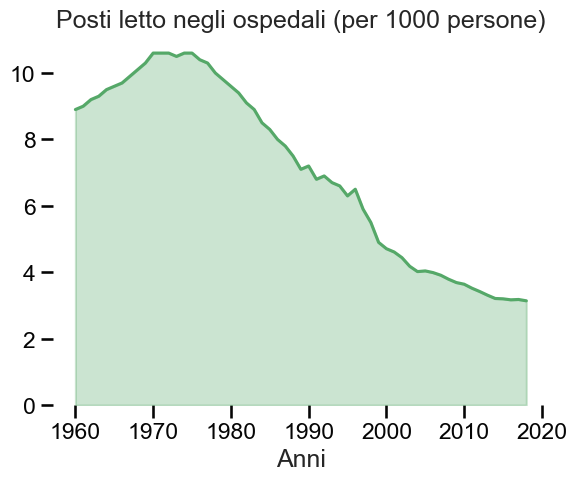

In [3]:
plot_ = sns.lineplot(beds, x="Year", y="Value", color=palette[2])
plt.fill_between(beds['Year'],beds['Value'],alpha=0.3, color=palette[2])
plt.ylim(0)
plot_.set(title="Posti letto negli ospedali (per 1000 persone)", xlabel='Anni',ylabel="")
#plt.savefig("posti_letto.png", bbox_inches='tight', transparent=True)
plt.show()

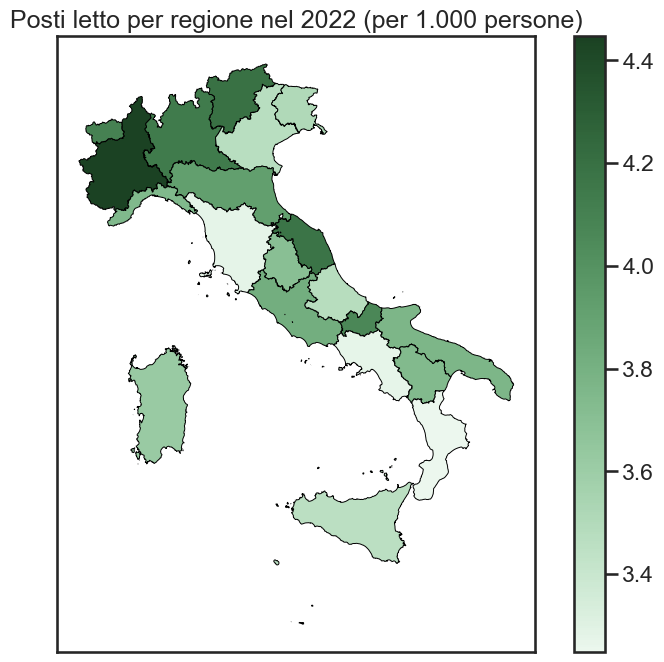

In [83]:
posti_letto_2022 = pd.read_csv("Datasets/Posti_letto_per_struttura_ospedaliera_2022.csv", sep=";",encoding='cp1252')
posti_letto_reg_2022 = posti_letto_2022[["Descrizione Regione","Totale posti letto"]]
posti_letto_reg_2022 = posti_letto_reg_2022.groupby(['Descrizione Regione']).sum()
trentino = posti_letto_reg_2022[posti_letto_reg_2022.index=='PROV. AUTON. BOLZANO']['Totale posti letto'].iloc[0]+posti_letto_reg_2022[posti_letto_reg_2022.index=='PROV. AUTON. TRENTO']['Totale posti letto'].iloc[0]
posti_letto_reg_2022 = posti_letto_reg_2022.drop('PROV. AUTON. BOLZANO')
posti_letto_reg_2022 = posti_letto_reg_2022.drop('PROV. AUTON. TRENTO')
posti_letto_reg_2022.loc['Trentino Alto Adige'] = trentino
posti_letto_reg_2022.sort_index(inplace=True)

pop_reg_2022 = pd.read_csv("Datasets/Popolazione_Regioni_2022.csv", sep=";",thousands=".",index_col=0)
pop_reg_2022.sort_index(inplace=True)
pop_reg_2022 = pop_reg_2022.drop('Provincia Autonoma Bolzano / Bozen')
pop_reg_2022 = pop_reg_2022.drop('Provincia Autonoma Trento')
pop_reg_2022 = pop_reg_2022.set_index(posti_letto_reg_2022.index)

posti_letto_reg_2022_norm = [x[1]["Totale posti letto"] / pop_reg_2022.loc[x[0]].values[0] *1000 for x in posti_letto_reg_2022.iterrows()]
regions = ['Abruzzo', 'Basilicata', 'Calabria', 'Campania', 'Emilia-Romagna',
       'Friuli Venezia Giulia', 'Lazio', 'Liguria', 'Lombardia', 'Marche',
       'Molise', 'Piemonte', 'Puglia', 'Sardegna', 'Sicilia', 'Toscana','Trentino-Alto Adige', 'Umbria', 'Valle d\'Aosta',
       'Veneto']
posti_letto_reg_2022_norm = pd.DataFrame([regions,posti_letto_reg_2022_norm]).transpose()
posti_letto_reg_2022_norm.columns = ['region','quantity']
posti_letto_reg_2022_norm.head()
letti_map_norm = posti_letto_reg_2022_norm.set_index('region').T.to_dict("list")

for key in letti_map_norm:
    letti_map_norm[key] = letti_map_norm[key][0]

sns.set_style("ticks")

# Load shapefile of Italy's regions
italy_regions = gpd.read_file('italy_regions.shp')

# Merge population data with shapefile
italy_regions['beds_norm'] = italy_regions['DEN_REG'].map(letti_map_norm)

colormap = sns.cubehelix_palette(start=2, rot=0, dark=.2, light=.95, reverse=False, as_cmap=True)
# Plot the map
ax = italy_regions.plot(column='beds_norm', cmap=colormap, edgecolor="black", figsize=(10, 8), linewidth=.7, legend=True)
ax.tick_params(left=False, bottom=False)
ax.set(xticklabels=[])
ax.set(yticklabels=[])
ax.set_facecolor("white")
plt.title('Posti letto per regione nel 2022 (per 1.000 persone)')
#plt.savefig("posti_letto_regioni.png", bbox_inches='tight', transparent=True)
plt.show()
#letti_map_norm

In [85]:
posti_letto_2020 = pd.read_csv("Datasets/Posti_letto_per_struttura_ospedaliera_2020.csv", sep=";",encoding='cp1252')
posti_letto_reg_2020 = posti_letto_2020[["Descrizione Regione","Totale posti letto"]]
posti_letto_reg_2020 = posti_letto_reg_2020.groupby(['Descrizione Regione']).sum()
trentino = posti_letto_reg_2020[posti_letto_reg_2020.index=='PROV. AUTON. BOLZANO']['Totale posti letto'].iloc[0]+posti_letto_reg_2020[posti_letto_reg_2020.index=='PROV. AUTON. TRENTO']['Totale posti letto'].iloc[0]
posti_letto_reg_2020 = posti_letto_reg_2020.drop('PROV. AUTON. BOLZANO')
posti_letto_reg_2020 = posti_letto_reg_2020.drop('PROV. AUTON. TRENTO')
posti_letto_reg_2020.loc['Trentino Alto Adige'] = trentino
posti_letto_reg_2020.sort_index(inplace=True)
pop_reg_2020 = pd.read_csv("Datasets/Popolazione_Regioni_2020.csv", sep=",")
pop_reg_2020.head()
pop_reg_2020 = pop_reg_2020.groupby(['Territorio']).sum()
pop_reg_2020 = pop_reg_2020[["Value"]]
pop_reg_2020 = pop_reg_2020.rename(columns={'Value':'Totale abitanti'})
pop_reg_2020.sort_index(inplace=True)
pop_reg_2020 = pop_reg_2020.drop('Provincia Autonoma Bolzano / Bozen')
pop_reg_2020 = pop_reg_2020.drop('Provincia Autonoma Trento')
pop_reg_2020 = pop_reg_2020.set_index(posti_letto_reg_2020.index)

posti_letto_reg_2020_norm = [x[1]["Totale posti letto"] / pop_reg_2020.loc[x[0]].values[0] *1000 for x in posti_letto_reg_2020.iterrows()]

regions = ['Abruzzo', 'Basilicata', 'Calabria', 'Campania', 'Emilia-Romagna',
       'Friuli Venezia Giulia', 'Lazio', 'Liguria', 'Lombardia', 'Marche',
       'Molise', 'Piemonte', 'Puglia', 'Sardegna', 'Sicilia', 'Toscana','Trentino-Alto Adige', 'Umbria', 'Valle d\'Aosta',
       'Veneto']
posti_letto_reg_2020_norm = pd.DataFrame([regions,posti_letto_reg_2020_norm]).transpose()
posti_letto_reg_2020_norm.columns = ['region','quantity']


letti_map_norm = posti_letto_reg_2020_norm.set_index('region').T.to_dict("list")

for key in letti_map_norm:
    letti_map_norm[key] = letti_map_norm[key][0]

sns.set_style("ticks")

# Load shapefile of Italy's regions
italy_regions = gpd.read_file('italy_regions.shp')

# Merge population data with shapefile
italy_regions['beds_norm'] = italy_regions['DEN_REG'].map(letti_map_norm)

colormap = sns.cubehelix_palette(start=2, rot=0, dark=.2, light=.95, reverse=False, as_cmap=True)
# Plot the map
#ax = italy_regions.plot(column='beds_norm', cmap=colormap, edgecolor="black", figsize=(10, 8), linewidth=.7, legend=True)
#ax.tick_params(left=False, bottom=False)
#ax.set(xticklabels=[])
#ax.set(yticklabels=[])
#ax.set_facecolor("white")
#plt.title('Posti letto per regione nel 2020 (per 1.000 persone)')
#plt.savefig("posti_letto_regioni.png", bbox_inches='tight', transparent=True)
#plt.show()

In [10]:
personale_medico = pd.read_csv("Datasets/Personale sanitario_regioni.csv", sep=";",decimal=",",thousands=".")
personale_medico.sort_index(inplace=True)
personale_medico_2022 = personale_medico[["Territorio","2022"]]

In [11]:
personale_medico_map = personale_medico_2022.set_index('Territorio').T.to_dict("list")

for key in personale_medico_map:
    personale_medico_map[key] = personale_medico_map[key][0]


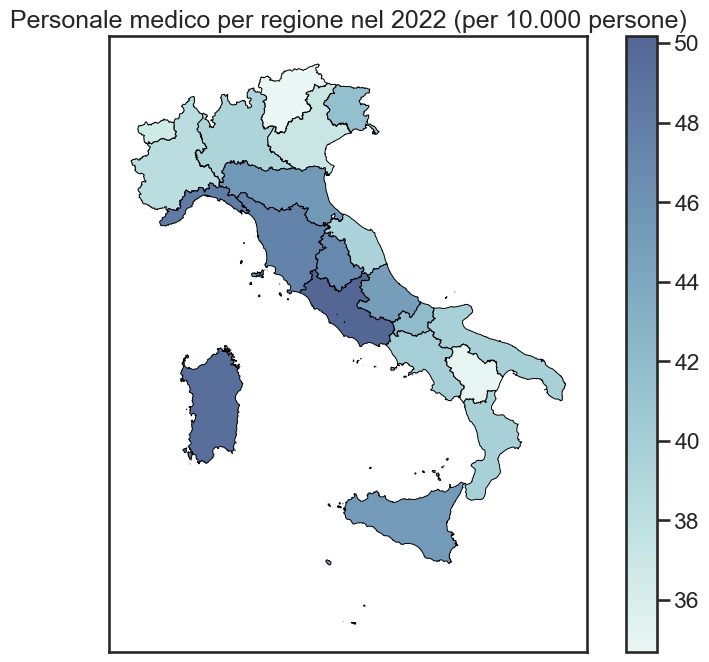

In [12]:
regions = ['Abruzzo', 'Basilicata', 'Calabria', 'Campania', 'Emilia-Romagna',
       'Friuli Venezia Giulia', 'Lazio', 'Liguria', 'Lombardia', 'Marche',
       'Molise', 'Piemonte', 'Puglia', 'Sardegna', 'Sicilia', 'Toscana','Trentino-Alto Adige', 'Umbria', 'Valle d\'Aosta',
       'Veneto']

# Load shapefile of Italy's regions
italy_regions = gpd.read_file('italy_regions.shp')

# Merge population data with shapefile
italy_regions['personale medico per 10000 persone'] = italy_regions['DEN_REG'].map(personale_medico_map)

colormap = sns.cubehelix_palette(start=.2, rot=-.3, dark=.4, light=.95, reverse=False, as_cmap=True)

# Plot the map
ax = italy_regions.plot(column='personale medico per 10000 persone', cmap=colormap, edgecolor="black", figsize=(10, 8), linewidth=.7, legend=True)

ax.tick_params(left=False, bottom=False)
ax.set(xticklabels=[])
ax.set(yticklabels=[])
ax.set_facecolor("white")

 
 
plt.title('Personale medico per regione nel 2022 (per 10.000 persone)')
#plt.savefig("personale_medico_regioni.png", bbox_inches='tight', transparent=True)
plt.show()

In [13]:
personale_medico = pd.read_csv("Datasets/Personale sanitario totale_2013_2022.csv", sep=";",decimal=",",thousands=".")
personale_medico = personale_medico.set_index("Profilo professionale").T
personale_medico.head()

Profilo professionale,Totale medici (generici e specialisti)
2013,38.95
2014,39.11
2015,38.70
2016,39.86
2017,40.25


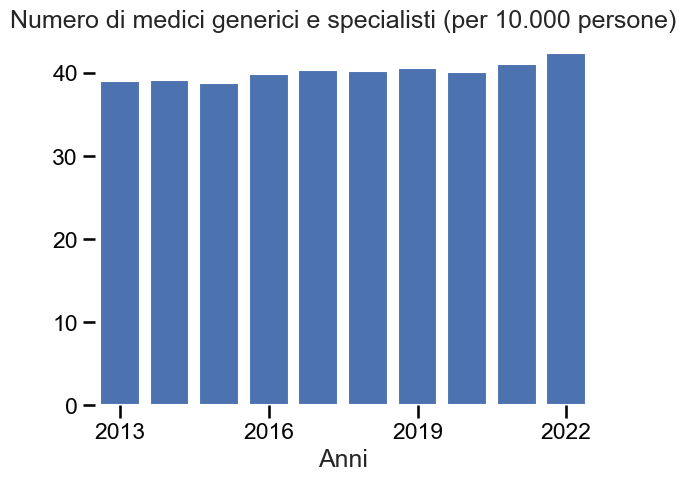

In [94]:
sns.set_style("white", {'xtick.bottom': True, 'ytick.left': True,  'xtick.color': '.02', 'ytick.color': '.02', 'axes.spines.right' : False, 'axes.spines.top' : False,'axes.spines.bottom' : False,'axes.spines.left' : False})
#NON TENGO CONTO DI INFERMIERI, FARMACISTI, ETC. IN QUESTO GRAFICO
plot_ = sns.barplot(personale_medico, x=personale_medico.index, y="Totale medici (generici e specialisti)", saturation=1)
plot_.set(title="Numero di medici generici e specialisti (per 10.000 persone)", xlabel='Anni', ylabel='')
plt.xticks(["2013","2016","2019","2022"])
plt.ylim(0)
#plt.savefig("numero_medici.png", bbox_inches='tight', transparent=True)
#print(personale_medico.loc[2022]*10000 - personale_medico.loc[2013]*10000)
plt.show()

In [95]:
personale_sanitario = pd.read_csv("Datasets/Personale sanitario_categorie.csv", sep=";",decimal=",",thousands=".")
personale_sanitario = personale_sanitario.set_index("Profilo professionale").T
personale_sanitario["Totale"] = personale_sanitario.sum(axis=1)
personale_sanitario
personale_sanitario.head()

Profilo professionale,Medici specialisti,Medici generici,Odontoiatri,Ostetriche,Professioni sanitarie infermieristiche,Farmacisti,Totale
2013,29.95,9.00,7.80,2.49,50.74,11.35,111.33
2014,30.24,8.86,7.89,2.59,53.17,11.65,114.40
2015,29.80,8.90,7.90,2.59,54.89,11.61,115.69
2016,30.87,8.99,8.08,2.75,56.14,11.66,118.49
2017,31.18,9.07,8.26,2.78,58.50,11.82,121.61


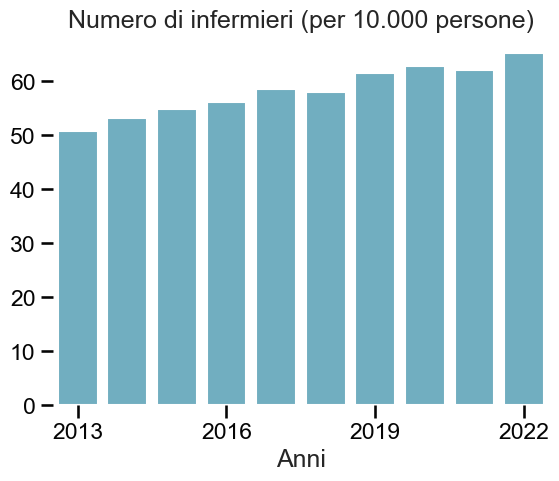

In [96]:
plot_ = sns.barplot(personale_sanitario, x=personale_sanitario.index, y="Professioni sanitarie infermieristiche", color=palette[9])
plot_.set(title="Numero di infermieri (per 10.000 persone)", xlabel='Anni', ylabel='')
plt.xticks(["2013","2016","2019","2022"])
plt.ylim(0)
#plt.savefig("numero_infermieri.png", bbox_inches='tight', transparent=True)
plt.show()

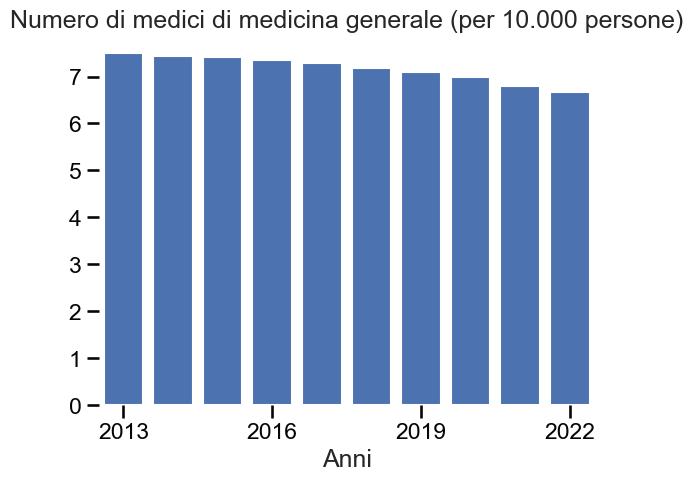

In [97]:
medici_anni = pd.read_csv("Datasets/Età_medici_2022.csv",sep=";",decimal=",",thousands=".",index_col=0)
popolazione = pd.read_csv("Datasets/popolazione_03_21.csv",sep=";",decimal=",",thousands=".",index_col=0)
medici_anni = medici_anni[medici_anni.index > 2012]
popolazione = popolazione[popolazione.index > 2012]
medici_norm = [x[1]["Totale"] / popolazione.loc[x[0]].values[0] * 10000 for x in medici_anni.iterrows()]
medici_norm = pd.DataFrame([popolazione.index.astype(int),medici_norm]).T
medici_norm.columns = ["Anno","Totale"]
medici_norm = medici_norm.astype({'Anno': 'int32'})

ax = sns.barplot(medici_norm,x="Anno",y="Totale", color=palette[0], saturation=1)
plt.ylim(0)
ax.set(title = "Numero di medici di medicina generale (per 10.000 persone)", xlabel='Anni', ylabel='')
plt.xticks(["2013","2016","2019","2022"])
#plt.savefig("numero_med_generale.png", bbox_inches='tight', transparent=True)
plt.show()


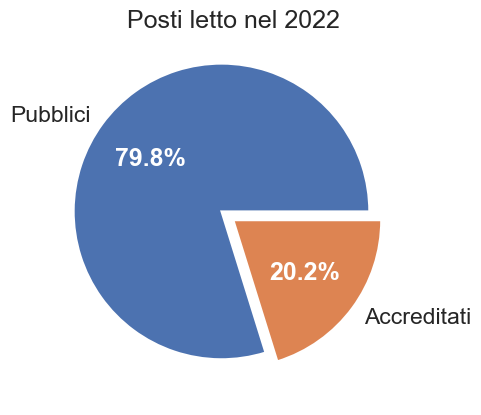

In [18]:
posti_letto_2022=pd.read_csv("Datasets/Posti_letto_2022.csv",sep=";",decimal=",",thousands=".", index_col=0)
posti_letto_2022=posti_letto_2022.drop("Totale posti letto")
myexplode=[0.1,0]
_,_,labels=plt.pie(posti_letto_2022.Totale,explode=myexplode,autopct='%1.1f%%',labels=["Pubblici","Accreditati"],colors=palette)
plt.title("Posti letto nel 2022")
plt.setp(labels,color='white',fontweight='bold')
#fontweight='bold'
#plt.savefig("posti_letto_pie.png", bbox_inches='tight', transparent=True)
plt.show()

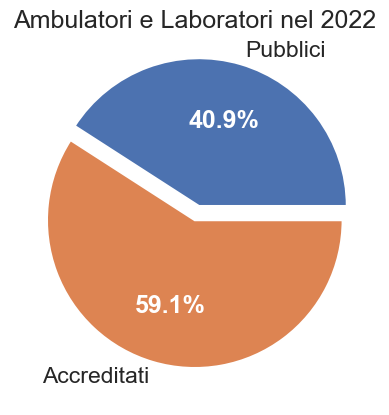

In [102]:
strutture_sanitarie_2022=pd.read_csv("Datasets/Strutture_sanitarie_2022.csv",sep=";",decimal=",",thousands=".", index_col=0)
myexplode=[0.1,0]
_,_,labels=plt.pie(strutture_sanitarie_2022["Ambulatori e Laboratori"],explode=myexplode,autopct='%1.1f%%',labels=["Pubblici","Accreditati"],colors=palette)
plt.title("Ambulatori e Laboratori nel 2022")
plt.setp(labels,color='white',fontweight='bold')
#plt.savefig("ambulatori_lab_pie.png", bbox_inches='tight', transparent=True)
plt.show()

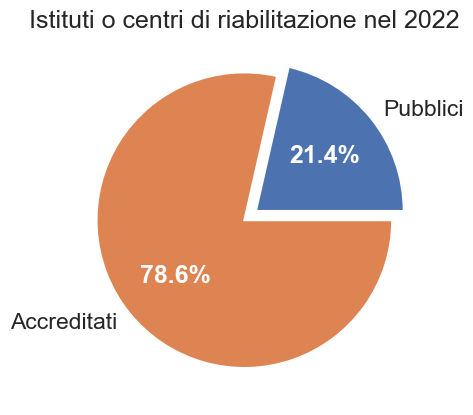

In [20]:
istituti_riabilitazione_2022 = pd.read_csv("Datasets/Istituti_riabilitazione_2022.csv",sep=";",decimal=",",thousands=".",index_col=0)
istituti_riabilitazione_2022
myexplode=[0.1,0]
_,_,labels=plt.pie(istituti_riabilitazione_2022["Quantità"].drop("Totale"),explode=myexplode,autopct='%1.1f%%',labels=["Pubblici","Accreditati"],colors=palette)
plt.title("Istituti o centri di riabilitazione nel 2022")
plt.setp(labels,color='white',fontweight='bold')
#plt.savefig("istituti_centri_riab.png", bbox_inches='tight', transparent=True)
plt.show()

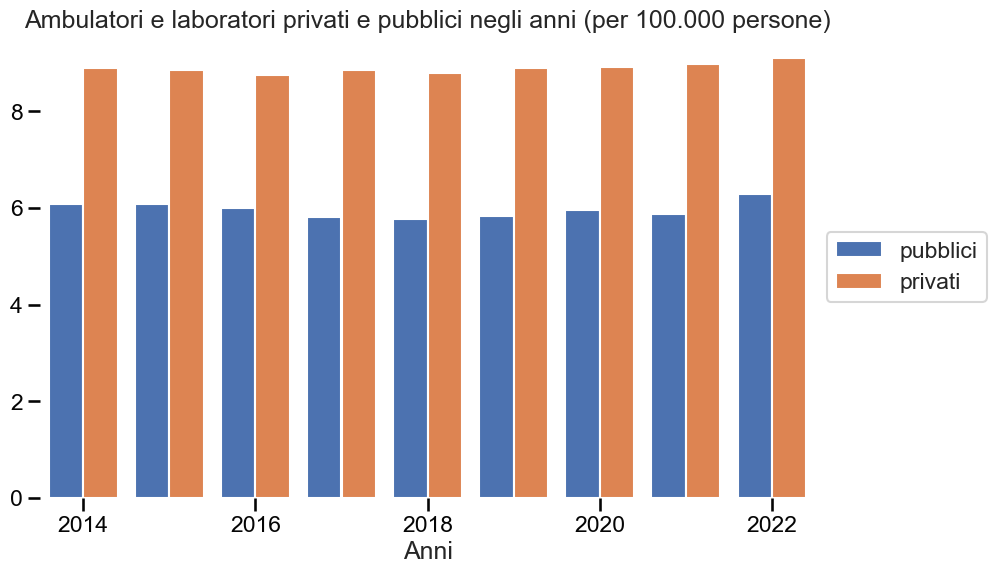

In [21]:
private_pubbliche_anni=pd.read_csv("Datasets/Strutture_private_pubbliche.csv",sep=";",decimal=",",thousands=".", index_col=0)
private_pubbliche_anni = private_pubbliche_anni.T
df_melted = private_pubbliche_anni.reset_index().melt(id_vars=["index"], var_name="Tipo Dato", value_name="Valore")

plt.figure(figsize=(10,6))
sns.barplot(df_melted, x='index', y='Valore', hue='Tipo Dato', palette=palette[0:2], saturation=1)
plt.title("Ambulatori e laboratori privati e pubblici negli anni (per 100.000 persone)")
plt.ylabel("")
plt.xlabel("Anni")
plt.xticks(["2014","2016","2018","2020","2022"])
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

#plt.savefig("ambulatori_lab_anni.png", bbox_inches='tight', transparent=True)
plt.show()

In [22]:
salaries = pd.read_csv("Datasets/doctor_salary_europe.csv")
salaries = salaries.drop(columns=["VAR", "UNIT", "COU", "YEA", "Flag Codes", "Flags"])
salaries = salaries[salaries["Measure"] == 'Salaried, income, US$ exchange rate']
salaries.loc[:,"Value"]=salaries.Value/1000

nurses = salaries[salaries["Variable"] == "Remuneration of hospital nurses"].drop(columns="Variable")
specialists = salaries[salaries["Variable"] == "Remuneration of specialists"].drop(columns="Variable")

In [23]:
nurses_it = nurses[nurses["Country"] == "Italy"].drop(columns=["Country","Measure"]).set_index("Year")
specialists_it = specialists[specialists["Country"] == "Italy"].drop(columns=["Country","Measure"]).set_index("Year")
nurses_it=nurses_it.rename(columns={"Value":"Infermieri"})
specialists_it=specialists_it.rename(columns={"Value":"Medici Specialisti"})
salaries_it = pd.merge(specialists_it,nurses_it,left_index=True,right_index=True)
salaries_it=salaries_it.reset_index().rename(columns={"Year":"index"})

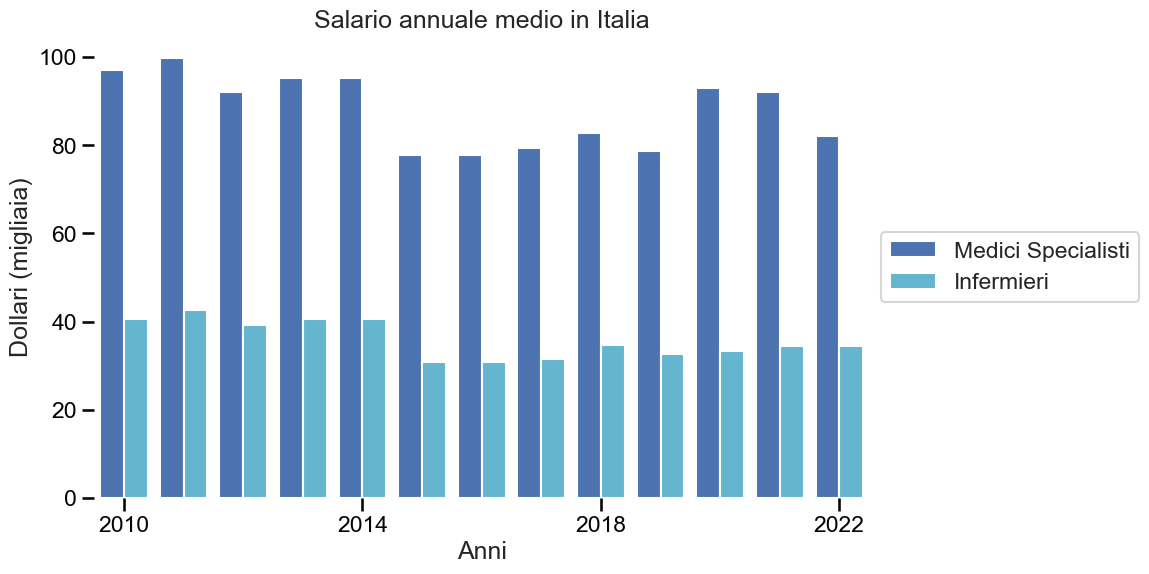

In [104]:
df_melted =  salaries_it.melt(id_vars=["index"], var_name="Tipo Dato", value_name="Valore")
plt.figure(figsize=(10,6))
sns.barplot(df_melted, x='index', y='Valore', hue='Tipo Dato', palette=[palette[0], palette[9]], saturation=1)
plt.title("Salario annuale medio in Italia")
plt.ylabel("Dollari (migliaia)")
plt.xlabel("Anni")
plt.xticks(["2010","2014","2018","2022"])
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
#plt.savefig("salario_annuale_italia.png", bbox_inches='tight', transparent=True)
plt.show()

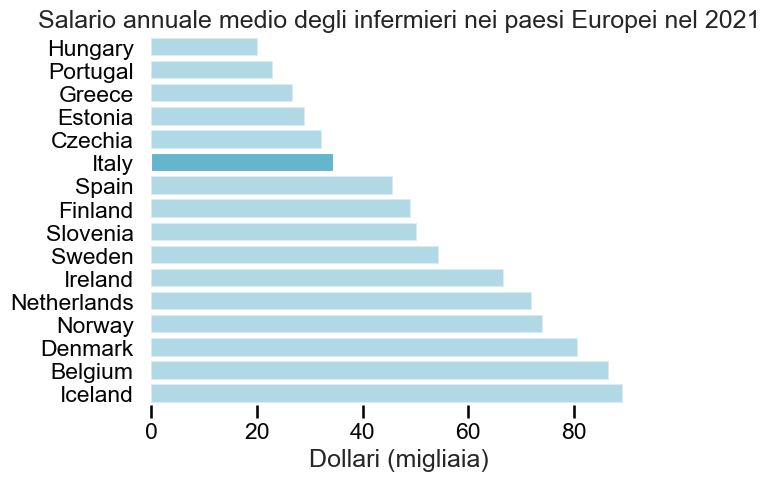

In [106]:
sns.set_style("white", {'xtick.bottom': True, 'ytick.left': False,  'xtick.color': '.02', 'ytick.color': '.02', 'axes.spines.right' : False, 'axes.spines.top' : False,'axes.spines.bottom' : False,'axes.spines.left' : False})
salaries2022 = salaries[salaries["Year"] == 2021].drop(columns=["Measure", "Year"])
salaries2022 =  salaries2022.drop(salaries2022[salaries2022.Country.isin(["Luxembourg","Mexico","Slovak Republic","Canada","New Zealand","Chile","Switzerland","United States","Türkiye","Australia","Israel","United Kingdom"])].index)
nurses2022 = salaries2022[salaries2022["Variable"] == "Remuneration of hospital nurses"]
ax = sns.barplot(nurses2022, x='Value', y='Country', color=palette[9], saturation=1, order=nurses2022.sort_values("Value").Country, alpha=0.5)
sns.barplot(nurses2022[nurses2022["Country"] == "Italy"], x='Value', y='Country', color=palette[9], saturation=1, order=nurses2022.sort_values("Value").Country, alpha=1, ax=ax)
plt.ylabel("")
plt.title("Salario annuale medio degli infermieri nei paesi Europei nel 2021")
plt.xlabel("Dollari (migliaia)")
#plt.savefig("salario_annuale_europa.png", bbox_inches='tight', transparent=True)
plt.show()

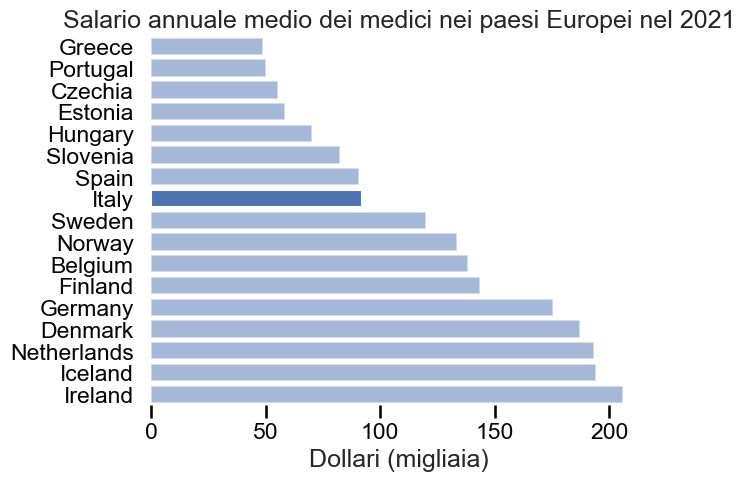

In [26]:
specialists2022 = salaries2022[salaries2022["Variable"] == "Remuneration of specialists"]
ax = sns.barplot(specialists2022, x='Value', y='Country', color=palette[0], saturation=1,order=specialists2022.sort_values("Value").Country, alpha=0.5)
sns.barplot(specialists2022[specialists2022["Country"] == "Italy"], x='Value', y='Country', color=palette[0], saturation=1,order=specialists2022.sort_values("Value").Country, alpha=1, ax=ax)
plt.title("Salario annuale medio dei medici nei paesi Europei nel 2021")
plt.ylabel("")
plt.xlabel("Dollari (migliaia)")
plt.show()

In [27]:
paesi = (specialists2022.Country).to_list()
paesi.append(["France","United Kingdom"])
expenditure = pd.read_csv("Datasets/expenditure_on_health.csv", encoding='latin-1')
expenditure_2020 = expenditure[expenditure["Year"] == 2020]
expenditure_2020 = expenditure_2020.drop(columns=["Region","Source","Footnotes"])
expenditure_gdp = expenditure_2020[expenditure_2020["Series"] == "Current health expenditure (% of GDP)"].drop(columns=["Series"])
expenditure_gdp = expenditure_gdp[expenditure_gdp["Country"].isin(paesi)]
expenditure_gdp.head()

,Country,Year,Value
193,Belgium,2020,11.1
541,Czechia,2020,9.2
565,Denmark,2020,10.5
673,Estonia,2020,7.8
721,Finland,2020,9.6


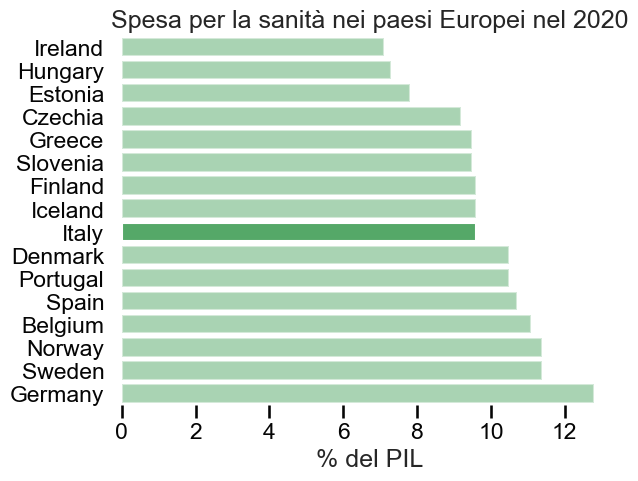

In [28]:
ax=sns.barplot(expenditure_gdp, x='Value', y='Country', color=palette[2], saturation=1,order=expenditure_gdp.sort_values("Value").Country, alpha=0.5)
sns.barplot(expenditure_gdp[expenditure_gdp["Country"] == "Italy"], x='Value', y='Country', color=palette[2], saturation=1,order=expenditure_gdp.sort_values("Value").Country, alpha=1, ax=ax)
plt.title("Spesa per la sanità nei paesi Europei nel 2020")
plt.ylabel("")
plt.xlabel("% del PIL")
plt.show()

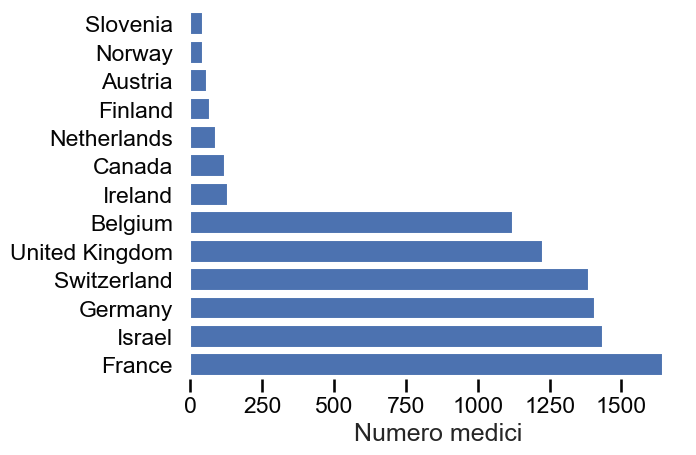

In [29]:
medici_esteri_per_paese = pd.read_csv("Datasets/medici_esteri_2021.csv",sep=",")
medici_esteri_per_paese = medici_esteri_per_paese.drop(columns=["COU","CO2","YEA","VAR","Variable","Flag Codes","Flags"])
medici_italiani_per_paese = medici_esteri_per_paese[medici_esteri_per_paese["Country of origin"]=="Italy"]
medici_italiani_per_paese_2022 = medici_italiani_per_paese[medici_italiani_per_paese["Year"]==2021]
medici_italiani_per_paese_2022 = medici_italiani_per_paese_2022.set_index("Country").drop(columns=["Year","Country of origin"]).sort_values(by='Value',ascending=True)
medici_italiani_per_paese_2022 = medici_italiani_per_paese_2022.drop(medici_italiani_per_paese_2022[medici_italiani_per_paese_2022.index.isin(["Chile","Estonia","Hungary","Czechia","New Zealand","Poland"])].index)
sns.barplot(medici_italiani_per_paese_2022, x='Value', y=medici_italiani_per_paese_2022.index, color=palette[0], saturation=1)
#plt.title("Numero di medici italiani all'estero per paese nel 2022")
plt.xlabel("Numero medici")
plt.ylabel("")
plt.savefig("medici_italiani_estero.png", bbox_inches='tight', transparent=True)
plt.show()

In [30]:
laureatiMedicina=pd.read_csv("Datasets/Laureati_medicina_2010_2021.csv", sep=";",decimal=",",thousands=".")
laureatiMedicina=laureatiMedicina.set_index("Anno").T
laureatiMedicina.head()

Anno,Laureati
2011,10961
2012,11717
2013,12255
2014,12393
2015,13515


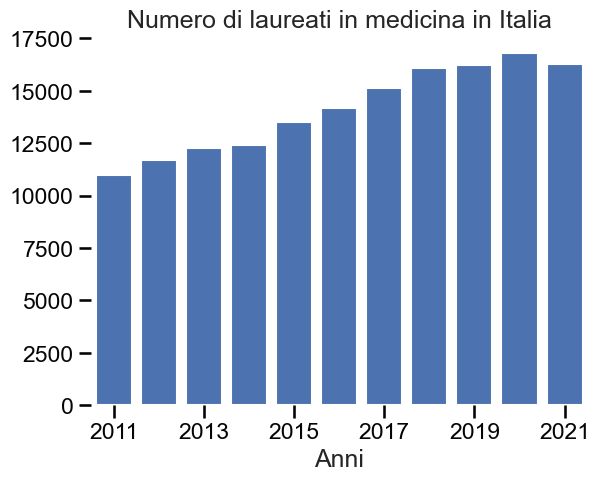

In [100]:
sns.set_style("white", {'xtick.bottom': True, 'ytick.left': True,  'xtick.color': '.02', 'ytick.color': '.02', 'axes.spines.right' : False, 'axes.spines.top' : False,'axes.spines.bottom' : False,'axes.spines.left' : False})
ax= sns.barplot(laureatiMedicina, x=laureatiMedicina.index, y="Laureati", color=palette[0], saturation=1)
ax.set(title="Numero di laureati in medicina in Italia",xlabel="Anni",ylabel="")
plt.xticks(["2011","2013","2015","2017","2019","2021"])
#plt.savefig("laureati_medicina.png", bbox_inches='tight', transparent=True)
plt.show()

In [32]:
medici_esteri_per_paese_inflow = pd.read_csv("Datasets/medici_esteri_annui.csv",sep=",")
medici_esteri_per_paese_inflow = medici_esteri_per_paese_inflow.drop(columns=["COU","CO2","YEA","VAR","Variable","Flag Codes","Flags"])
medici_italiani_per_paese_inflow = medici_esteri_per_paese_inflow[medici_esteri_per_paese_inflow["Country of origin"]=="Italy"]
medici_italiani_outflow = medici_italiani_per_paese_inflow.groupby(["Year"]).sum()
medici_italiani_outflow = medici_italiani_outflow.loc[2011:2021]
medici_italiani_outflow.head()

,Country,Country of origin,Value
Year,,,
2011,AustriaBelgiumCanadaDenmarkFinlandFranceGerman...,ItalyItalyItalyItalyItalyItalyItalyItalyItalyI...,1030
2012,AustriaBelgiumCanadaDenmarkFinlandFranceGerman...,ItalyItalyItalyItalyItalyItalyItalyItalyItalyI...,1086
2013,AustriaBelgiumCanadaDenmarkFinlandFranceGerman...,ItalyItalyItalyItalyItalyItalyItalyItalyItalyI...,1306
2014,AustriaBelgiumCanadaDenmarkFinlandFranceGerman...,ItalyItalyItalyItalyItalyItalyItalyItalyItalyI...,1616
2015,AustriaBelgiumCanadaDenmarkFinlandFranceGerman...,ItalyItalyItalyItalyItalyItalyItalyItalyItalyI...,1112


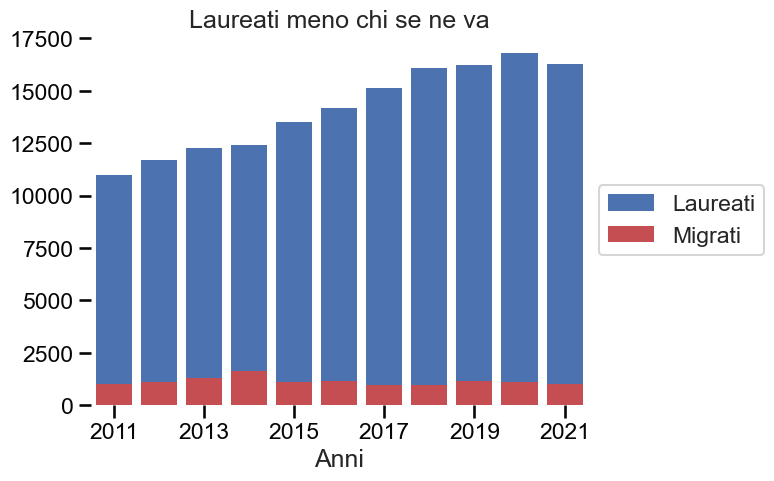

In [33]:
import matplotlib.patches as mpatches

fig, ax = plt.subplots()
blue = sns.barplot(laureatiMedicina, x=laureatiMedicina.index, y="Laureati", color=palette[0], saturation=1, linewidth=0, label="Laureati")
red = sns.barplot(medici_italiani_outflow, x=laureatiMedicina.index, y="Value", color=palette[3], saturation=1, linewidth=0, label="Migrati")
ax = blue
ax = red
ax.set(title="Laureati meno chi se ne va",xlabel="Anni",ylabel="")

handles = []
handles.append(mpatches.Patch(color=palette[0], label="Laureati"))
handles.append(mpatches.Patch(color=palette[3], label="Migrati"))


ax.legend(handles=handles)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.xticks(["2011","2013","2015","2017","2019","2021"])
plt.show()

In [34]:
medici_privati_pubblici = pd.read_csv("Datasets/medici_privati_pubblici.csv",sep=";")
medici_privati_pubblici['Femmine'] = -medici_privati_pubblici['Femmine']
medici_privati_pubblici.head()

,Classi di età,Femmine,Maschi,Totale
0,20-29,-3263,2713,5977
1,30-39,-6704,4759,11463
2,40-49,-4872,3486,8358
3,50-59,-4854,6024,10878
4,60+,-15890,31903,47793


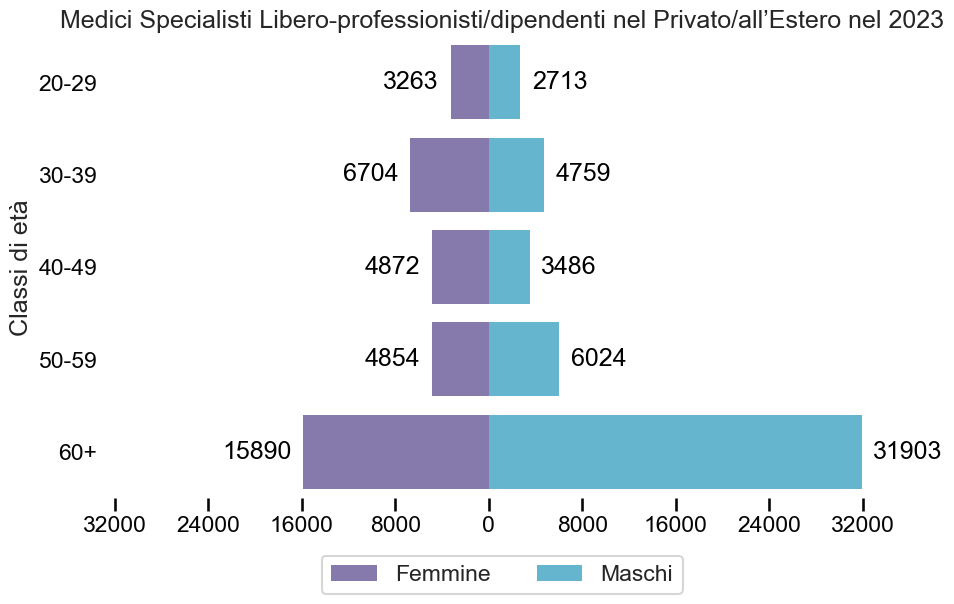

In [35]:
def round_up_to_base(n, base):
    return math.ceil(n / base) * base

sns.set_style("white", {'xtick.bottom': True, 'ytick.left': False,  'xtick.color': '.02', 'ytick.color': '.02', 'axes.spines.right' : False, 'axes.spines.top' : False,'axes.spines.bottom' : False,'axes.spines.left' : False})


# Crea la figura e gli assi
fig, ax = plt.subplots(figsize=(10, 6))

# Crea i grafici a barre orizzontali
sns.barplot(x='Femmine', y='Classi di età', data=medici_privati_pubblici, label='Femmine', color=palette[4], orient='h', linewidth=0,)
sns.barplot(x='Maschi', y='Classi di età', data=medici_privati_pubblici, label='Maschi', color=palette[9], saturation=1, orient='h', linewidth=0,)

# Aggiunge etichette e titolo
ax.set(xlabel='', ylabel='Classi di età', title="Medici Specialisti Libero-professionisti/dipendenti nel Privato/all’Estero nel 2023")
max_population = max(medici_privati_pubblici['Maschi'].max(), -medici_privati_pubblici['Femmine'].min())
max_population = round_up_to_base(max_population, 1000)

ticks = range(-max_population, max_population + 1000, 8000)
ax.set_xticks(ticks)
ax.set_xticklabels([abs(x) for x in ticks])

# Aggiunge le annotazioni sulle barre
for i in range(medici_privati_pubblici.shape[0]):
    femmine_val = medici_privati_pubblici['Femmine'][i]
    maschi_val = medici_privati_pubblici['Maschi'][i]
    ax.text(femmine_val - 1000, i, str(femmine_val*-1), color='black', ha="right", va="center")
    ax.text(maschi_val + 1000, i, str(maschi_val), color='black', ha="left", va="center")

ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=2)

plt.show()

In [36]:
spesa_sanitaria_ita = pd.read_csv("Datasets/spesa_sanitaria_ita.csv",sep=",",thousands=".")
spesa_sanitaria_ita.astype({"Anno": str})
spesa_sanitaria_ita.set_index("Anno", inplace=True)
spesa_sanitaria_ita = spesa_sanitaria_ita.div(1000000000)
spesa_sanitaria_ita.drop(columns=["Fondo Sanitario Nazionale"], inplace=True)
spesa_sanitaria_ita = spesa_sanitaria_ita.sum(axis=1)

fondo_sanitario_ita = pd.read_csv("Datasets/spesa_sanitaria_ita.csv",sep=",",thousands=".")
fondo_sanitario_ita.astype({"Anno": str})
fondo_sanitario_ita.set_index("Anno", inplace=True)
fondo_sanitario_ita = fondo_sanitario_ita["Fondo Sanitario Nazionale"]
fondo_sanitario_ita = fondo_sanitario_ita.div(1000000000)

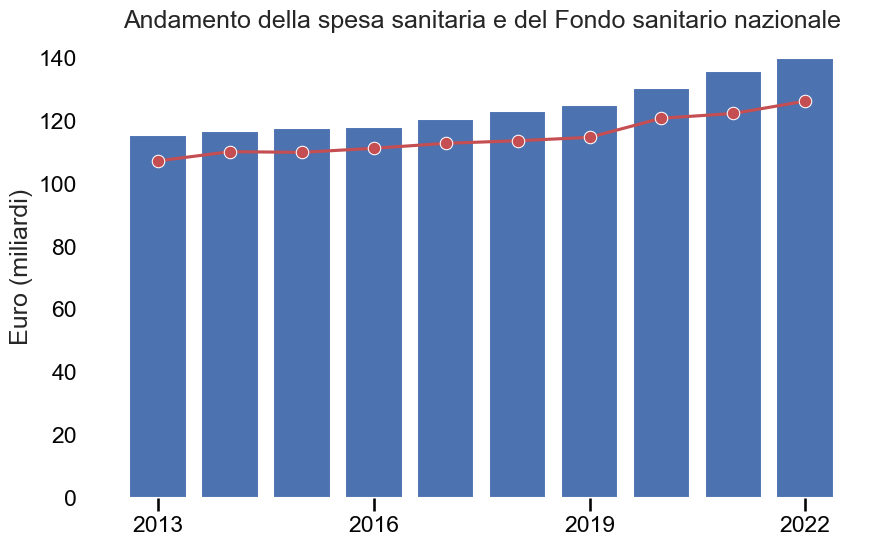

In [37]:
# Conversione degli indici in stringa
spesa_sanitaria_ita.index = spesa_sanitaria_ita.index.astype(str)
fondo_sanitario_ita.index = fondo_sanitario_ita.index.astype(str)

df1 = spesa_sanitaria_ita.reset_index()
df1.columns = ['Anno', 'Valore1']
df2 = fondo_sanitario_ita.reset_index()
df2.columns = ['Anno', 'Valore2']

df1 = df1.drop(df1[df1.Anno.isin(["2012"])].index)
df2 = df2.drop(df2[df2.Anno.isin(["2012"])].index)

# Creazione del grafico
plt.figure(figsize=(10, 6))

# Barplot per il primo dataset
ax = sns.barplot(x='Anno', y='Valore1', data=df1, color=palette[0],saturation=1)

# Lineplot per il secondo dataset
ax = sns.lineplot(x='Anno', y='Valore2', data=df2, color=palette[3], marker='o')

ax.set(xlabel='', ylabel='Euro (miliardi)', title="Andamento della spesa sanitaria e del Fondo sanitario nazionale")
plt.xticks(["2013","2016","2019", "2022"])

plt.show()